<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Авторы материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, аналитик Вымпелком Саян Омаров

# <center> Домашнее задание № 5
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

In [1]:
import numpy as np
from sympy import binomial

In [2]:
p = np.sum([binomial(5,i)*(0.7**i)*(0.3**(5-i)) for i in range(3,6)])
print(round(p*100,1))

83.7


#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	     ----Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                         ---- Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	----Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio ----	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	----Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate ----Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse----	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; ; тип -	integer
* NumberOfDependents ----Число человек в семье кредитозаёмщика; тип -	integer

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [4]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [5]:
## Считываем данные
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [6]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

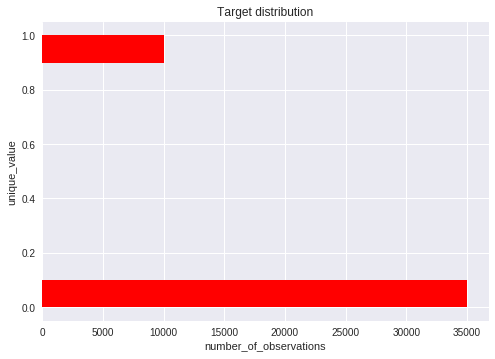

In [7]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [8]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names


['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [9]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table =delete_nan(data)


In [10]:
## Разделяем таргет и признаки 
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". (используйте пример из статьи. Поставьте np.random.seed(0) как это сделано в статье)

In [11]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
### Ваш код должен быть здесь ###
age_ser = data[data.SeriousDlqin2yrs == 1].age.values

In [13]:
np.random.seed(0)
age_ser_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(age_ser, 1000)]
print("Service calls from loyal:  mean interval",  stat_intervals(age_ser_mean_scores, 0.05))

Service calls from loyal:  mean interval [ 45.68145322  46.16947187]


## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [15]:
auc_score = make_scorer(roc_auc_score)

In [16]:
### Ваш код должен быть здесь ###
grid_s = GridSearchCV(lr,parameters,cv=skf,scoring=auc_score,verbose=1,n_jobs=-1)

In [17]:
grid_s.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=1)

In [18]:
grid_s.grid_scores_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:699: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.70327, std: 0.00488, params: {'C': 0.0001},
 mean: 0.72044, std: 0.00662, params: {'C': 0.001},
 mean: 0.71681, std: 0.00372, params: {'C': 0.01},
 mean: 0.71352, std: 0.00309, params: {'C': 0.1},
 mean: 0.71399, std: 0.00357, params: {'C': 1},
 mean: 0.71335, std: 0.00407, params: {'C': 10}]

**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [19]:
### Ваш код должен быть здесь ###
grid_s.best_score_

0.72044228634958674

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [20]:
import tensorflow as tf
from sklearn import preprocessing

In [21]:
X_norm = preprocessing.StandardScaler().fit_transform(X)

In [22]:
lregr = LogisticRegression(random_state=5,C=0.001, class_weight= 'balanced')

In [23]:
lregr.fit(X_norm,y)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
lregr.coef_

array([[-0.41630368,  0.72400432, -0.02408186,  0.51767292,  0.19473217,
        -0.16286353,  0.10132603]])

In [25]:
### Ваш код должен быть здесь ###
est = np.abs(lregr.coef_)
est 

array([[ 0.41630368,  0.72400432,  0.02408186,  0.51767292,  0.19473217,
         0.16286353,  0.10132603]])

In [26]:
np.argmax(est)

1

**Задание 6.** Посчитайте долю влияния `DebtRatio` на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [27]:
import tensorflow as tf
from sklearn import preprocessing

In [41]:
sess = tf.Session()

sess.run(tf.nn.softmax(lregr.coef_))

array([[ 0.07715192,  0.2413105 ,  0.11420537,  0.19632139,  0.14213998,
         0.09940641,  0.12946443]])

**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [30]:
### Ваш код должен быть здесь ###
w_age=grid_s.best_estimator_.coef_[0][0]

In [31]:
np.exp(w_age*20)

0.69509577259180255

# Случайный лес

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [33]:
### Ваш код должен быть здесь ###
grid_s = GridSearchCV(rf, parameters, cv = skf, scoring = auc_score,\
                      verbose=1, n_jobs = -1)

In [34]:
grid_s.fit(X,y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(roc_auc_score), verbose=1)

In [ ]:
import pickle

In [ ]:
with open("grid_forest","wb") as f:
    pickle.dump(grid_s,f)

In [35]:
grid_s.best_score_

0.7610280263937601

**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [36]:
### Ваш код должен быть здесь ###
np.argmin(grid_s.best_estimator_.feature_importances_)

6

** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

# Бэггинг

In [37]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить бэггинг классификатор. В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Так же не забудьте передать параметр валидации cv и `random_state=1`. Какая лучшая точность получилась?

In [55]:
### Ваш код должен быть здесь ###
b_logr = BaggingClassifier(LogisticRegression(class_weight= 'balanced'),\
                           n_estimators=100,random_state=42)
r_gridlog = RandomizedSearchCV(b_logr, parameters, cv = skf,n_iter=20,\
                               scoring=auc_score,verbose=1, n_jobs = -1,random_state=1)

In [56]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']

In [57]:
X_new = table[independent_columns_names]

In [58]:
r_gridlog.fit(X_new,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
          error_score='raise',
          estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm... n_estimators=100, n_jobs=1, oob_score=False,
         random_state=42, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score=True, scoring=make_scorer(roc_auc_score),
          verbose=1)

In [ ]:
with open("r_gridlog","wb") as f:
    pickle.dump(r_gridlog,f)

In [60]:
r_gridlog.best_score_

0.729875039926834

In [ ]:
r_gridlog.

In [ ]:
r_gridlog.best_params_

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации